<a href="https://colab.research.google.com/github/tlmakinen/imnn/blob/0.2a5/IMNN_shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd ./cosmo-field/

/mnt/home/tmakinen/repositories/imnn/cosmo-field


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from IMNN import IMNN
from IMNN.LFI import LFI
#from make_data import GenerateGaussianNoise
#from make_data import AnalyticLikelihood
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfd = tfp.distributions



# for autograd functions
#import jax.numpy as jnp
#from jax import grad, jit, vmap
#from jax import random
#import jax.scipy.special as jspecial

#import numpyro
#import numpyro
#import numpyro.distributions as dist

#key = random.PRNGKey(0)


print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__))

IMNN 0.2a5
TensorFlow 2.3.0
TensorFlow Probability 0.11.0
numpy 1.18.5


In [3]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type  == "GPU"]

In [4]:
get_available_gpus()

['/device:GPU:0']

In [5]:
print(tf.__version__)

2.3.0


# IMNN power spectrum model
Let's try to find a toy problem in which methods like the linear MOPED method fails to recover accurate fiducial parameters, and the IMNN (perhaps) succeeds. Let's start by generating 2D Gaussian maps according to the power law
$$ P(k) = Ak^{-B} $$
where the "cosmological" amplitude $A$ and power law $B$ are our two parameters of interest. We'll first start by varying just these two parameters, but it will be interesting then to consider a foreground contribution
$$ P_{\rm fg} = Ck^{-D} $$
(maybe with a much larger variance?) where $C >> A$ such that the cosmological field is obscured by a smoother, more intense foreground. Can the IMNN network pick out these parameters ? (We'll get to this in another notebook)
___

# optimal estimator
For our vanilla power spectrum inference, it is useful to recall the sufficient statistic (the power spectrum) for Gaussian fields using the Fisher Information criterion. By the Cramèr-Rao bound, we know that the error on a parameter $\theta_\alpha$ is bounded by
$$  \sigma_{\theta_{\alpha}} \geq \sqrt{F_{\alpha \alpha}}  $$ 
where the Fisher matrix is defined as
$$ F_{ij} = \frac{\partial S_\alpha}{\partial \theta_i} C_{\alpha \beta }^{-1} \frac{\partial S_\beta}{\partial \theta_j}$$

In our vanilla power spectrum model, we have the partials:
$$ \begin{align} 
      \frac{\partial P(k)}{\partial B} &= BA k^{(B-1)} \\ 
     \\
      \frac{\partial P(k)}{\partial A} &= k^{(B)} = \frac{P(k)}{A} \\
    \end{align} $$
We can estimate the covariance as diagonal, using the model:
$$ C_{\alpha \beta} = \frac{2 P^2(k_\alpha)}{N_{k_\alpha}}\delta_{\alpha \beta} $$
where $N_{k_\alpha}$ is the number of modes in the given $k_\alpha$ bin. The Fisher matrix can then be computed as:
$$ F =  \begin{bmatrix}
\sum_\alpha k_\alpha^B \left(\frac{2 P^2(k)}{N_k}\right)^{-1} k_\alpha^B & 0 \\
0 &  \sum_\alpha BA k^{(B-1)}  \left(\frac{2 P^2(k)}{N_k}\right)^{-1} BA k^{(B-1)}\\
\end{bmatrix} 
$$

For fiducial values $\theta_{\rm fid} = \{A, B\} = \{ 1.0, 0.8\}$ over a $k$ range (1, 128), , the determinant of our Fisher matrix evaluates to 
$$ F =  \begin{bmatrix}
\sum_\alpha k_\alpha^B \left(\frac{2 P^2(k)}{N_k}\right)^{-1} k_\alpha^B & 0 \\
0 &  \sum_\alpha BA k^{(B-1)}  \left(\frac{2 P^2(k)}{N_k}\right)^{-1} BA k^{(B-1)}\\
\end{bmatrix} 
$$

In [6]:
from make_2Dfield import GenerateCosmoField

Let's take a look at a single simulation of our data:

/mnt/home/tmakinen/repositories/imnn/cosmo-field/make_2Dfield.py:57: RuntimeWarning: divide by zero encountered in power
  return amp*np.power(k, -n)


(<Figure size 432x288 with 2 Axes>, None)

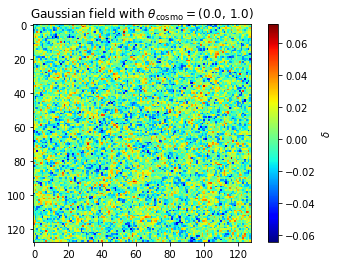

In [7]:
generator = GenerateCosmoField(input_shape=(1,128,128))

θ_target = np.array([1, 0.8])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

### define fiducial parameters

In [8]:
# define fiducial parameters and create data vector, d
θ_fid = np.array([1, 0.8]) # scale, power

In [10]:
SN = GenerateCosmoField(n_s=100, n_d=100, input_shape=(1,128,128), θ_fid=θ_fid)
# this is where we'd load in data if we didn't have a simulator
details, fiducial, validation_fiducial, derivative, validation_derivative = SN.generate_data()  

b0 shape :  (100, 1, 128, 128)


In [11]:
print("fiducial = {}\nvalidation_fiducial = {}\nderivative = {}\nvalidation_derivative = {}".format(
    fiducial.shape, validation_fiducial.shape, derivative.shape, validation_derivative.shape))

fiducial = (100, 1, 128, 128)
validation_fiducial = (100, 1, 128, 128)
derivative = (100, 2, 2, 1, 128, 128)
validation_derivative = (100, 2, 2, 1, 128, 128)


Now le but: We want to know firstly how well IMNN can tackle this problem, given a fiducial model to train on. Goals for right now:


1.   Train IMNN on fiducial parameters (set $\theta_{\rm fid} = (1.0, 0.8)$)
2.   Add foreground power spectrum on top



In [12]:
def fiducial_loader(seed, data):
    yield data[seed], seed

def derivative_loader(seed, derivative, parameter, data):
    yield data[seed, derivative, parameter], (seed, derivative, parameter)

## NN model
We're going to construct a neural network model for processing the gaussian $128 \times 128$ fields akin to the one in [Paco's paper](https://arxiv.org/pdf/2011.05992.pdf). Instead of dogs, cats, boats, and birds, we'll condense down to $\theta$, our simulation parameters (no pooling):

![model](https://missinglink.ai/wp-content/uploads/2019/07/A-Convolutional-Neural-Network.png)

In [55]:
def field2Dmodel(input_shape, n_summaries, strides=2, kernel=3,
                growth_factor=2, filters=8, dense_size=2):
    s = strides
    k = kernel
    growth_factor = growth_factor
    filters = filters
    dense_size = dense_size

    size = input_shape[-1]

    layers = [tf.keras.Input(shape=input_shape),
         tf.keras.layers.Reshape(input_shape[::-1])]
    while size > dense_size:
        # update filters
        filters *= growth_factor
        layers += [tf.keras.layers.Conv2D(filters,k, strides=s, padding='same'),
                    tf.keras.layers.LayerNormalization(),
                    tf.keras.layers.LeakyReLU(0.2)]
        # update tensor size
        size //= growth_factor

    # add dense layer to final output
    layers += [
        tf.keras.layers.Reshape((filters*size*s,)),
         tf.keras.layers.Dense(n_summaries)
    ]

    return tf.keras.Sequential(layers)

In [56]:
m = field2Dmodel(SN.input_shape, 1)
m.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_42 (Reshape)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
layer_normalization_65 (Laye (None, 64, 64, 16)        32        
_________________________________________________________________
leaky_re_lu_137 (LeakyReLU)  (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
layer_normalization_66 (Laye (None, 32, 32, 32)        64        
_________________________________________________________________
leaky_re_lu_138 (LeakyReLU)  (None, 32, 32, 32)      

In [20]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=SN.input_shape[:]),
     tf.keras.layers.Reshape(SN.input_shape[::-1]),
     tf.keras.layers.Conv2D(16,3, strides=2, padding='same'),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(32,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(64,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(128,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(256,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(512,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(1024,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Reshape((1024,)),
     tf.keras.layers.Dense(SN.n_summaries), 
    ])
opt = tf.keras.optimizers.Adam()

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
layer_normalization_28 (Laye (None, 32, 32, 32)        64        
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)       

In [37]:
imnn = IMNN.IMNN(n_s=SN.n_s, n_d=SN.n_d, n_params=SN.n_params, n_summaries=SN.n_summaries,
                 model=model, optimiser=opt, θ_fid=θ_fid, δθ=np.array([0.1,0.1]), input_shape=SN.input_shape,
                 fiducial=lambda x : fiducial_loader(x, fiducial), 
                 derivative=lambda x, y, z : derivative_loader(x, y, z, derivative), 
                 validation_fiducial=lambda x : fiducial_loader(x, validation_fiducial),
                 validation_derivative=lambda x, y, z : derivative_loader(x, y, z, validation_derivative), 
                 at_once=SN.n_s, check_shape=True, verbose=True,
                 directory="model", filename="gauss", save=True, load=True, weights='weights')

input shape will be (1, 128, 128)


In [39]:
imnn.load_w

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [52]:
imnn.fit(patience=10, min_iterations=20, tqdm_notebook=False, checkpoint=100)






Iterations: 0it [00:00, ?it/s]

Using patience length of 10. Maximum number of training iterations is 10000000000.
Saving current model in model/gauss







Iterations: 0it [00:06, ?it/s, det_F=0.00589, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00742, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0]




Iterations: 1it [00:06,  6.45s/it, det_F=0.00589, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00742, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0]




Iterations: 1it [00:12,  6.45s/it, det_F=0.00589, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00742, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0]




Iterations: 2it [00:12,  6.44s/it, det_F=0.00589, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00742, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0]




Iterations: 2it [00:19,  6.44s/it, det_F=0.0059, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00739, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0] 




Iterations: 3it [00:19,  6.43s/it, det_F=0.0059, det_C=4.34e-7, det_Cinv=2.3e+6, r=10, val_det_F=0.00739, val_det_C=3.46e-7, val_det_Cinv=2.89e+6, patience=0]




Iterations: 3it 

Reached 10 steps without increasing val_det_F. Resetting weights to iteration 24.


ValueError: x and y must have same first dimension, but have shapes (519,) and (518,)

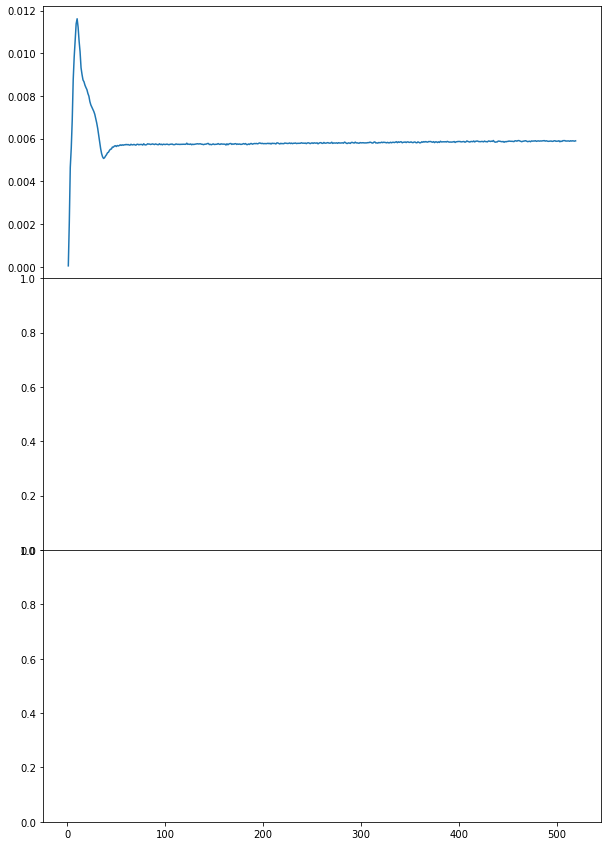

In [54]:
imnn.plot()

/mnt/home/tmakinen/repositories/imnn/cosmo-field/make_2Dfield.py:57: RuntimeWarning: divide by zero encountered in power
  return amp*np.power(k, -n)


(<Figure size 432x288 with 2 Axes>, None)

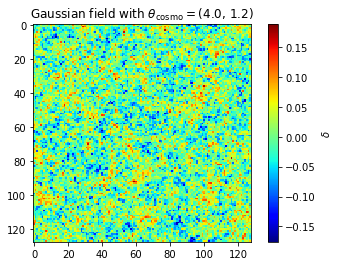

In [42]:
generator = GenerateCosmoField()

θ_target = np.array([4.0, 1.2])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, pars=θ_target, label="Observed data")

In [43]:
prior = tfd.Blockwise([tfd.Uniform(0.0, 10.0),
                       tfd.Uniform(-1.0, 5)])

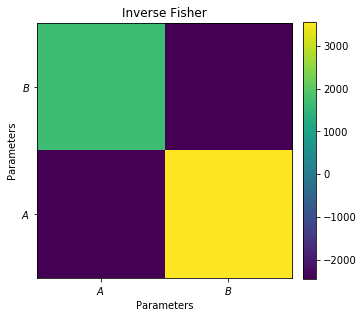

In [44]:
GA = LFI.GaussianApproximation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    labels=[r"$A$", r"$B$"])

GA.plot_Fisher(figsize=(5, 5));


/mnt/home/tmakinen/repositories/imnn/IMNN/LFI/LFI.py:233: RuntimeWarning: invalid value encountered in true_divide
  (grid[i_][1] - grid[i_][0]))
/mnt/home/tmakinen/repositories/imnn/IMNN/LFI/LFI.py:252: RuntimeWarning: invalid value encountered in true_divide
  (grid[j_][1] - grid[j_][0]))
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid valu

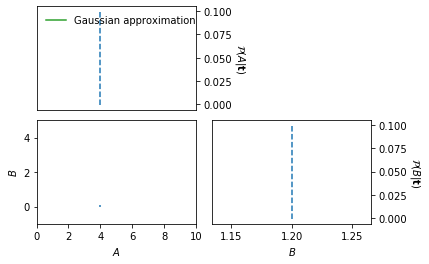

In [45]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')

#ax[0][1].plot(np.ones(10)*np.pi/2, np.linspace(-0.001,0.05, 10))
ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,0.1, 10), linestyle='--')

In [46]:
# run ABC computation
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, None, None, {"input_shape": SN.input_shape}),
    labels=[r"$A$", r"$B$"])

KeyboardInterrupt: 

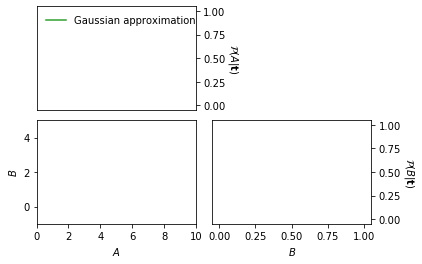

In [47]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ϵ=1.0,
    accepted=1000,
    draws=4000,
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(0.5),
    smoothing=0,
    bins=50);


ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,1.0, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,5.0, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1.5, 10), linestyle='--', color='k')

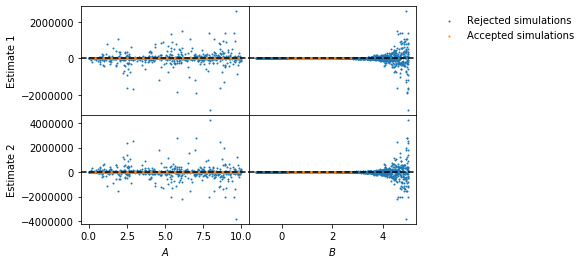

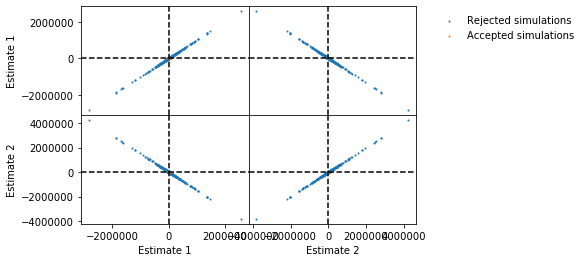

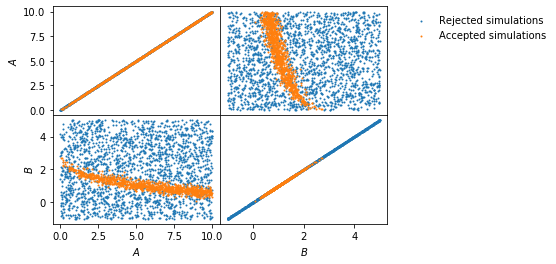

In [69]:
ABC.scatter_plot(axes="parameter_estimate", rejected=0.01);
ABC.scatter_plot(axes="estimate_estimate", rejected=0.01);
ABC.scatter_plot(axes="parameter_parameter", rejected=0.01);

In [48]:
PMC = LFI.PopulationMonteCarlo(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, None, None, {"input_shape": SN.input_shape}),
    labels=[r"$A$", r"$B$"])

In [49]:
PMC.PMC(draws=5000, initial_draws=8000, criterion=0.5, tqdm_notebook=False)





Iterations: 0it [00:00, ?it/s]



Iterations: 1it [00:10, 10.30s/it]



Iterations: 1it [00:10, 10.30s/it, criterion=[1.275], draws=[3923.], ε=[17.311]]



Iterations: 3it [00:17,  8.32s/it, criterion=[1.275], draws=[3923.], ε=[17.311]]



Iterations: 3it [00:17,  8.32s/it, criterion=[1.879], draws=[6584.], ε=[11.708]]



Iterations: 6it [00:25,  6.63s/it, criterion=[1.879], draws=[6584.], ε=[11.708]]



Iterations: 6it [00:25,  6.63s/it, criterion=[1.666], draws=[9586.], ε=[10.011]]



Iterations: 10it [00:35,  5.34s/it, criterion=[1.666], draws=[9586.], ε=[10.011]]



Iterations: 10it [00:35,  5.34s/it, criterion=[1.404], draws=[13146.], ε=[8.616]]



Iterations: 15it [00:44,  4.33s/it, criterion=[1.404], draws=[13146.], ε=[8.616]]



Iterations: 15it [00:44,  4.33s/it, criterion=[1.344], draws=[16867.], ε=[7.39]] 



Iterations: 21it [00:55,  3.57s/it, criterion=[1.344], draws=[16867.], ε=[7.39]]



Iterations: 21it [00:55,  3.57s/it, criterion=[1.193], draws=[21057.], ε=[6.342]

In [50]:
θ_fid

array([1. , 0.8])

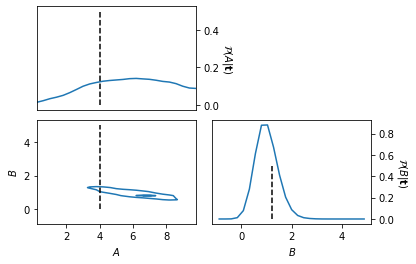

In [51]:
ax = PMC.plot(smoothing=1)
ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.5, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,5, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,.5, 10), linestyle='--', color='k')


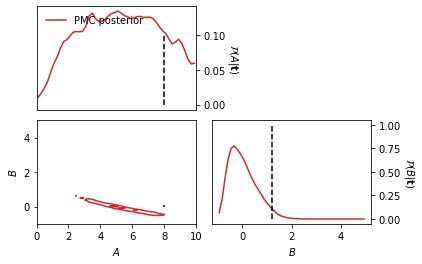

In [41]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label=None);

# ax = ABC.plot(
#     gridsize=(1000, 1000),
#     ϵ=0.5,
#     accepted=2000,
#     draws=100000,
#     ax=ax,
#     color="C1",
#     label="ABC posterior at ϵ={}".format(0.5),
#     smoothing=0,
#     bins=50);

foo = PMC.plot(
    draws=5000,
    initial_draws=8000,
    criterion=0.5,
    percentile=75,
    ax=ax,
    color="C3",
    label="PMC posterior",
    smoothing=1,
    bins=50);

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1., 10), linestyle='--', color='k')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x154f45fa5a50>,
      dtype=object)

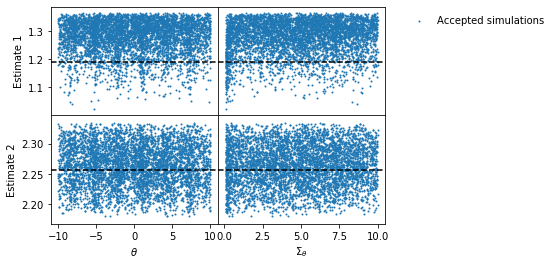

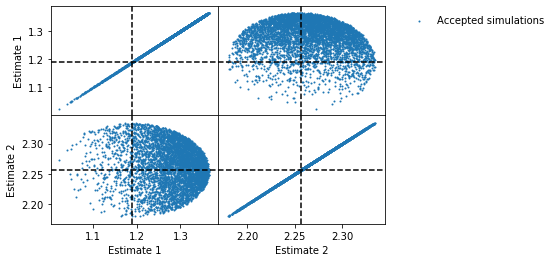

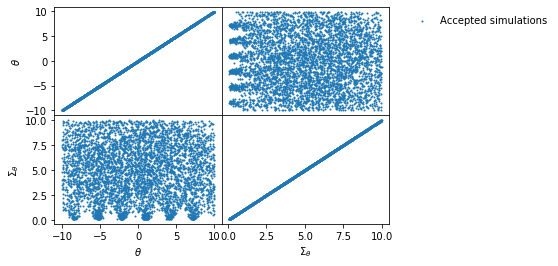

In [100]:
PMC.scatter_plot(axes="parameter_estimate")
PMC.scatter_plot(axes="estimate_estimate")
PMC.scatter_plot(axes="parameter_parameter")

In [15]:
import py21cmfast as p21c

In [29]:
coeval8, coeval9, coeval10 = p21c.run_coeval(
    redshift = [8.0, 9.0, 10.0],
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    astro_params = p21c.AstroParams({"HII_EFF_FACTOR":20.0}),
    random_seed=12345
)

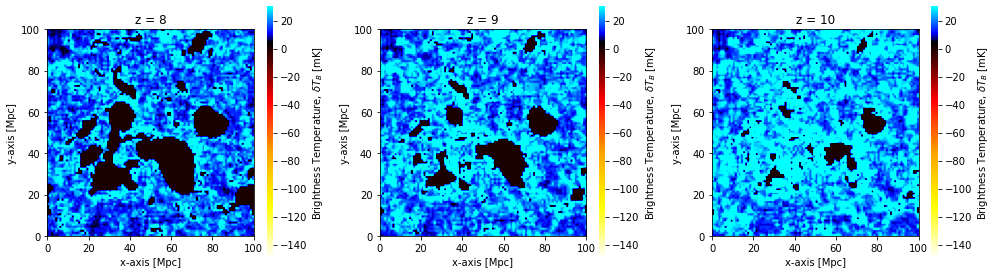

In [31]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    p21c.plotting.coeval_sliceplot(coeval, ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()

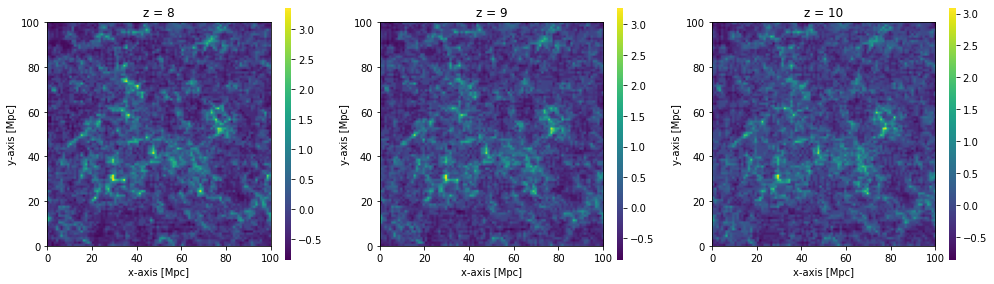

In [32]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    p21c.plotting.coeval_sliceplot(coeval, kind='density', ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()